# 군집분석

In [1]:
import sys
sys.path.append('./data_prep')
sys.path.append('./models')

In [2]:
from clustering_models import service_type_sep, make_scaled_df, num_of_components, feature_explained_variance,\
                            scree_plot, elbow_method, k_distance_plot, clustering_model, cluster_evaluation, comparison_of_scores_kmeans,\
                            cluster_visualization, cluster_separation, clusters_center, compare_columns, cluster_center_visualize, visualize_service_type, comparison_of_scores_dbscan
from data_preparation import get_data, get_cluster_df, get_regression_df
# from EDA import box_plt, skew_kurt_graph

from itertools import product

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
# font_name = fm.FontProperties(fname="/Users/leeseohyun/Library/Fonts/AppleGothic.ttf").get_name()
# mpl.rc('font', family=font_name)
plt.rcParams["axes.unicode_minus"] = False

## 데이터 불러오기
- AWS EC2 인스턴스에서 MySQL DB 새엉 
- 현재 AWS 인스턴스가 존재하지 않아서 CSV파일 직접 불러옴

In [3]:
''' 
# 전처리된 데이터 불러오기 

cnx = pymysql.connect(user='mt-1', password='1111', host='ec2-15-152-249-56.ap-northeast-3.compute.amazonaws.com', database='zigbang_project')
query = 'SELECT * FROM zigbang_project.zb_final_cluster;'
df = pd.read_sql(query, cnx)
cnx.close()
'''

# 군집분석에 맞는 전처리된 데이터 불러오기 
clustering_df = get_cluster_df()

## 군집 모델링 기법 선정 과정

In [4]:
# 스케일된 데이터 생성
# scaling : MinMax, Standard, Robust 
standard_df, minmax_df, robust_df, df_ohe = make_scaled_df(clustering_df)

### 차원축소를 위한 주성분 개수 후보 (누적기여율 70~80% 선정 )

|Unscaled|Standard Scaled|Minmax Scaled|Robust Scaled|
|-|-|-|-| 
|2|16~19|9~11|7~10|

In [ ]:
num_of_components(clustering_df)

|Unscaled|Standard Scaled|
| -------------------------------------- | -------------------------------------- |
|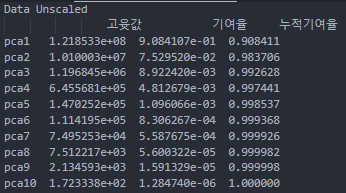|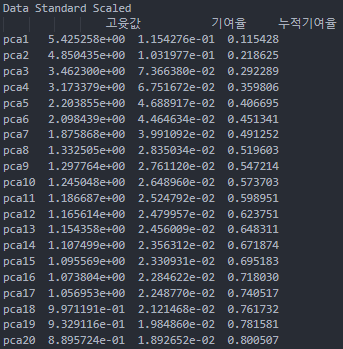|

|Minmax Scaled|Robust Scaled|
| -------------------------------------- | -------------------------------------- |
|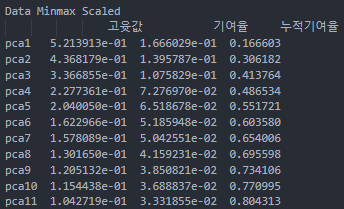|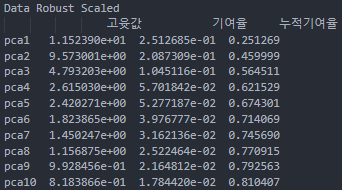|







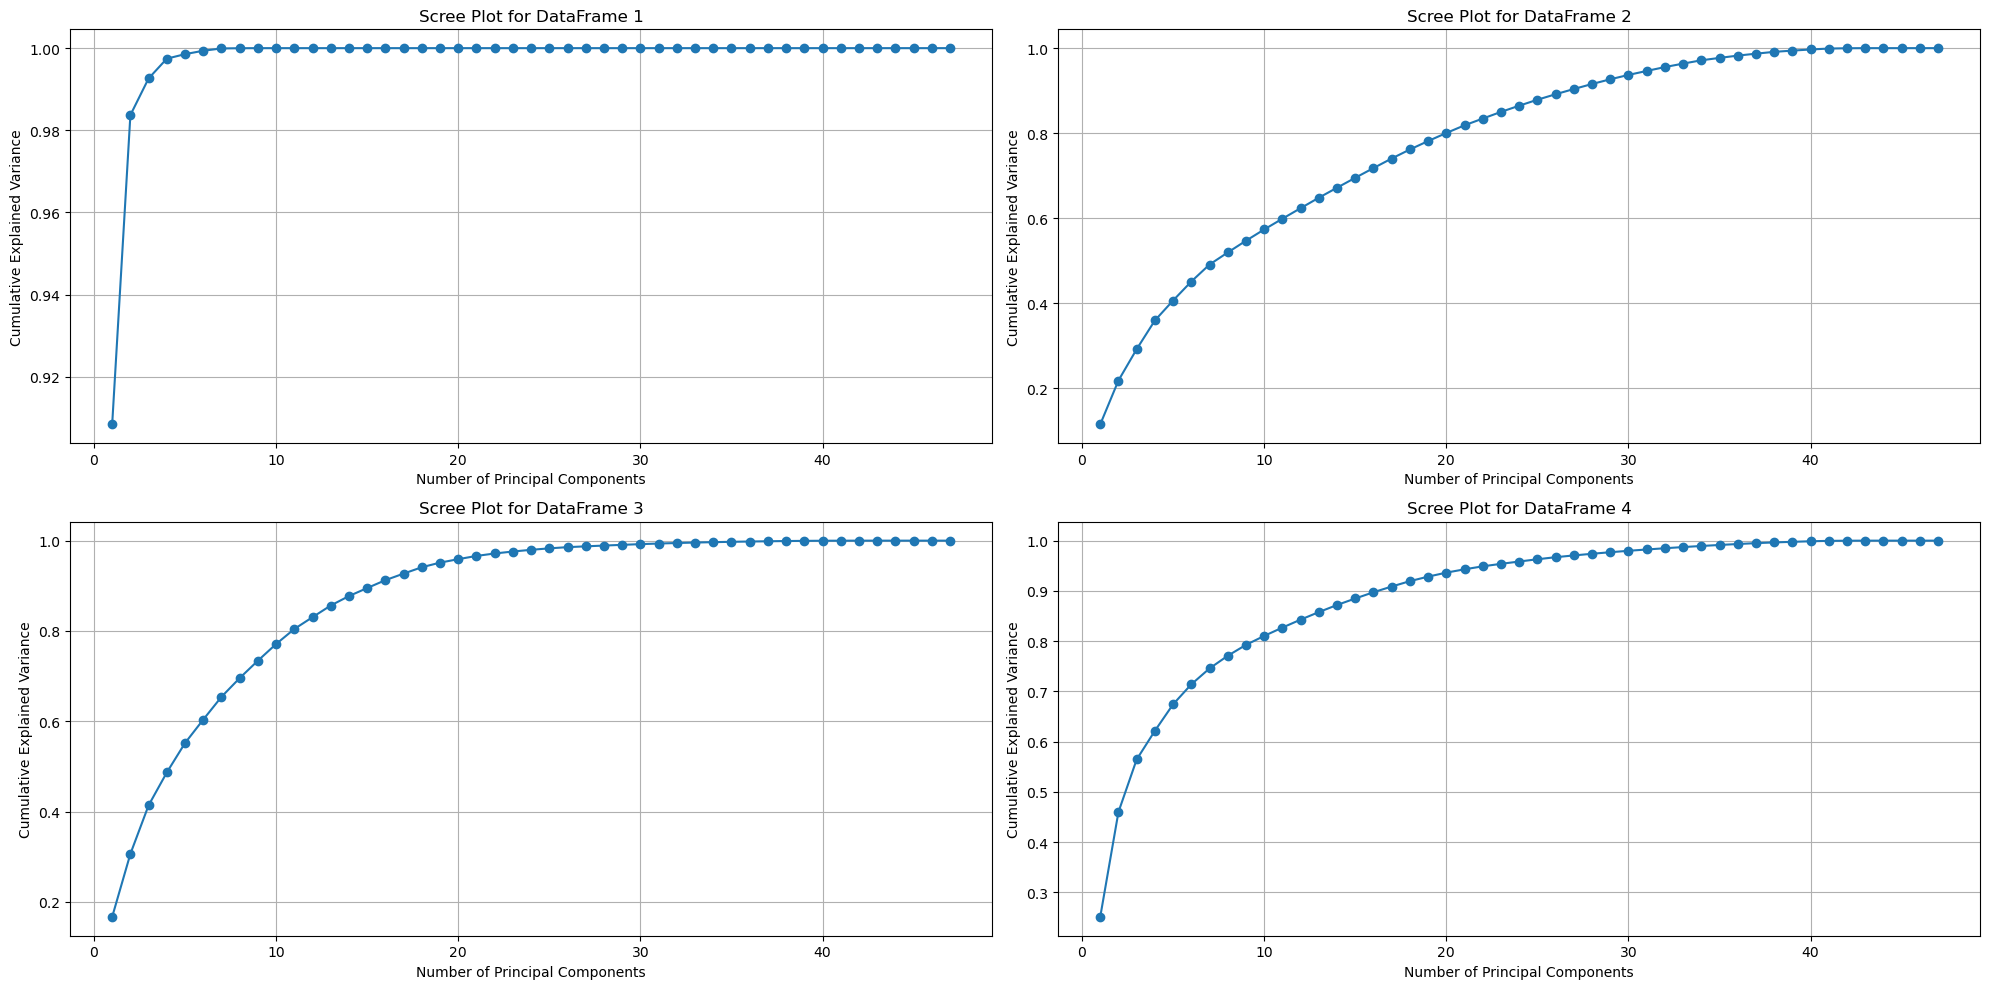

In [5]:
scree_plot(clustering_df)

### 군집 개수 후보 선정 

|Unscaled|Standard Scaled|Minmax Scaled|Robust Scaled|
| -------------------------------------- | -------------------------------------- | -------------------------------------- | -------------------------------------- | 
|2~5|5~8|3~6|3~6|

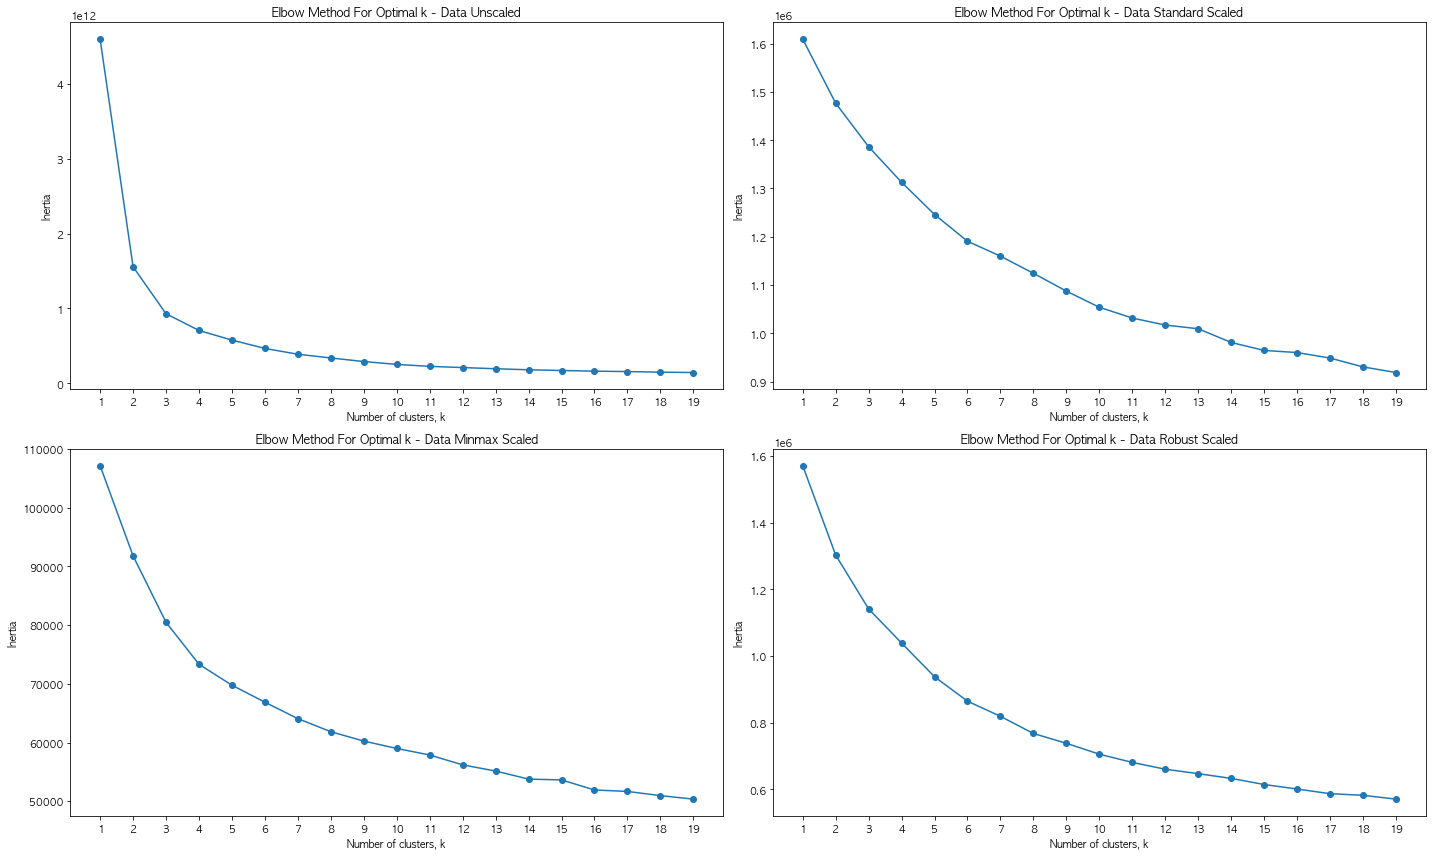

In [40]:
elbow_method(clustering_df)

### 1) KMeans

1. 모델에 적용될 파라미터들을 조합해보고 실루엣 계수 비교 
2. 각 스케일러별 점수가 좋은 파라미터 조합을 선택하고 모델에 적용하여 시각화해보기
3. 3차원 시각화 결과를 통해 군집별로 데이터가 고르게 분포되었는지 확인 

Args:
- dataframe (pd.DataFrame): 입력 데이터프레임
- method (str) : 군집 알고리즘('KMeans', 'DBSCAN', 'MeanShift')
- scaling_method (str): 스케일링 방법('standard', 'minmax', 'robust', 'unscaled')
- dim_reduction_method (str): 차원 축소 방법('PCA', 'TruncatedSVD')
- n_components (int): 차원 축소 후의 컴포넌트 개수
- n_clusters (int): 클러스터의 개수 in KMeans
- eps (int) : epsilon in DBSCAN

In [ ]:
params = {
    'method': ['KMeans'],
    'scaling_method': ['minmax'], #['unscaled'], 'standard', 'minmax', 'robust']
    'dim_reduction_method' : ['PCA', 'TruncatedSVD'],
    'n_components': [9, 10, 11],  # [2],[16, 17, 18, 19], [9, 10, 11], [7, 8, 9, 10]]
    'n_clusters': [3, 4, 5, 6] #[2, 3, 4, 5], [5, 6, 7, 8], [3, 4, 5, 6], [3, 4, 5, 6]]
}

param_combinations = product(*params.values())

comparison_of_scores_kmeans(clustering_df, param_combinations, params)

|Unscaled|Standard Scaled|
| -------------------------------------- | -------------------------------------- |
|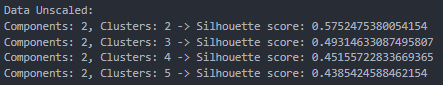|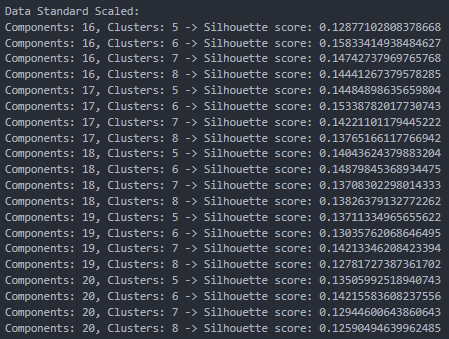|

|Minmax Scaled|Robust Scaled|
| -------------------------------------- | -------------------------------------- |
|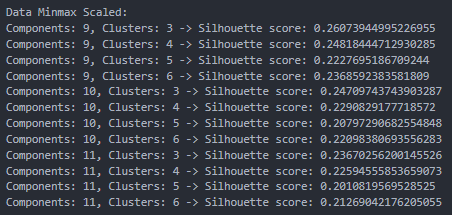|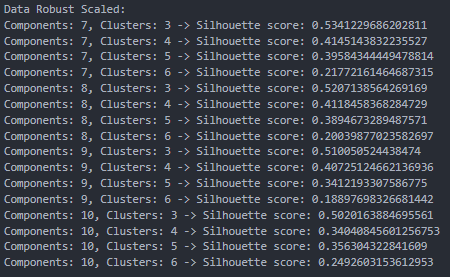|

### 스케일링 기법 선정

Unscaled

cluster_visualization(clustering_df, method = 'KMeans', scaling_method = 'unscaled', dim_reduction_method='PCA', n_components = 2, n_clusters = 3)<br>
cluster_visualization(clustering_df, method = 'KMeans', scaling_method = 'unscaled', dim_reduction_method='TruncatedSVD', n_components = 2, n_clusters = 4)

Standard Scaled

cluster_visualization(clustering_df, method = 'KMeans', scaling_method = 'standard', dim_reduction_method='PCA', n_components = 2, n_clusters = 3)<br>
cluster_visualization(clustering_df, method = 'KMeans', scaling_method = 'standard', dim_reduction_method='TruncatedSVD', n_components = 2, n_clusters = 4)

Robust Scaled 

cluster_visualization(clustering_df, method = 'KMeans', scaling_method = 'Robust', dim_reduction_method='PCA', n_components = 2, n_clusters = 3)<br>
cluster_visualization(clustering_df, method = 'KMeans', scaling_method = 'Robust', dim_reduction_method='TruncatedSVD', n_components = 2, n_clusters = 4)

Minmax Scaled

cluster_visualization(clustering_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='PCA', n_components = 9, n_clusters = 3)<br>
cluster_visualization(clustering_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='TruncatedSVD', n_components = 9, n_clusters = 3)

### Minmax 최종 선택
- n_components=9 일때 TruncatedSVD 실루엣 계수는 높지만 시각화 결과 PCA를 이용해 차원을 축소한 데이터로 적합한 모델에서 군집이 더 잘 나뉜 것으로 판단 


In [ ]:
cluster_visualization(clustering_df, method='KMeans', scaling_method='minmax', dim_reduction_method='PCA', n_components=9, n_clusters=3)
cluster_visualization(clustering_df, method='KMeans', scaling_method='minmax', dim_reduction_method='TruncatedSVD', n_components=9, n_clusters=3)

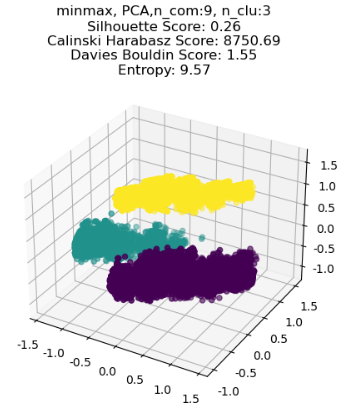 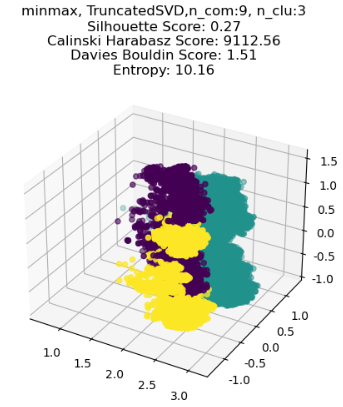

최종 군집 개수 선정
- KMeans 최종모델 선정 
- params: n_components = 9, n_clusters = 3 

In [ ]:
cluster_visualization(clustering_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='PCA', n_components = 9, n_clusters = 3)
cluster_visualization(clustering_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='PCA', n_components = 9, n_clusters = 6)


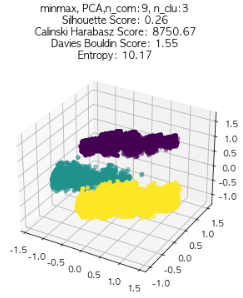 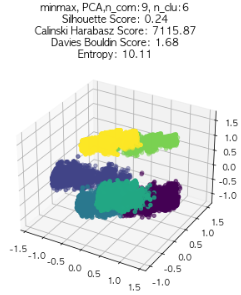

### 2) DBSCAN
1. elbow method 시각화를 통해 최적의 eps값 후보 선정
2. 모델에 적용될 파라미터들을 조합해서 실루엣 계수 확인
3. 3차원 시각화 결과를 통해 군집 결과 확인

eps : 0.25 ~ 0.5 / Minmax Scaler 적용 

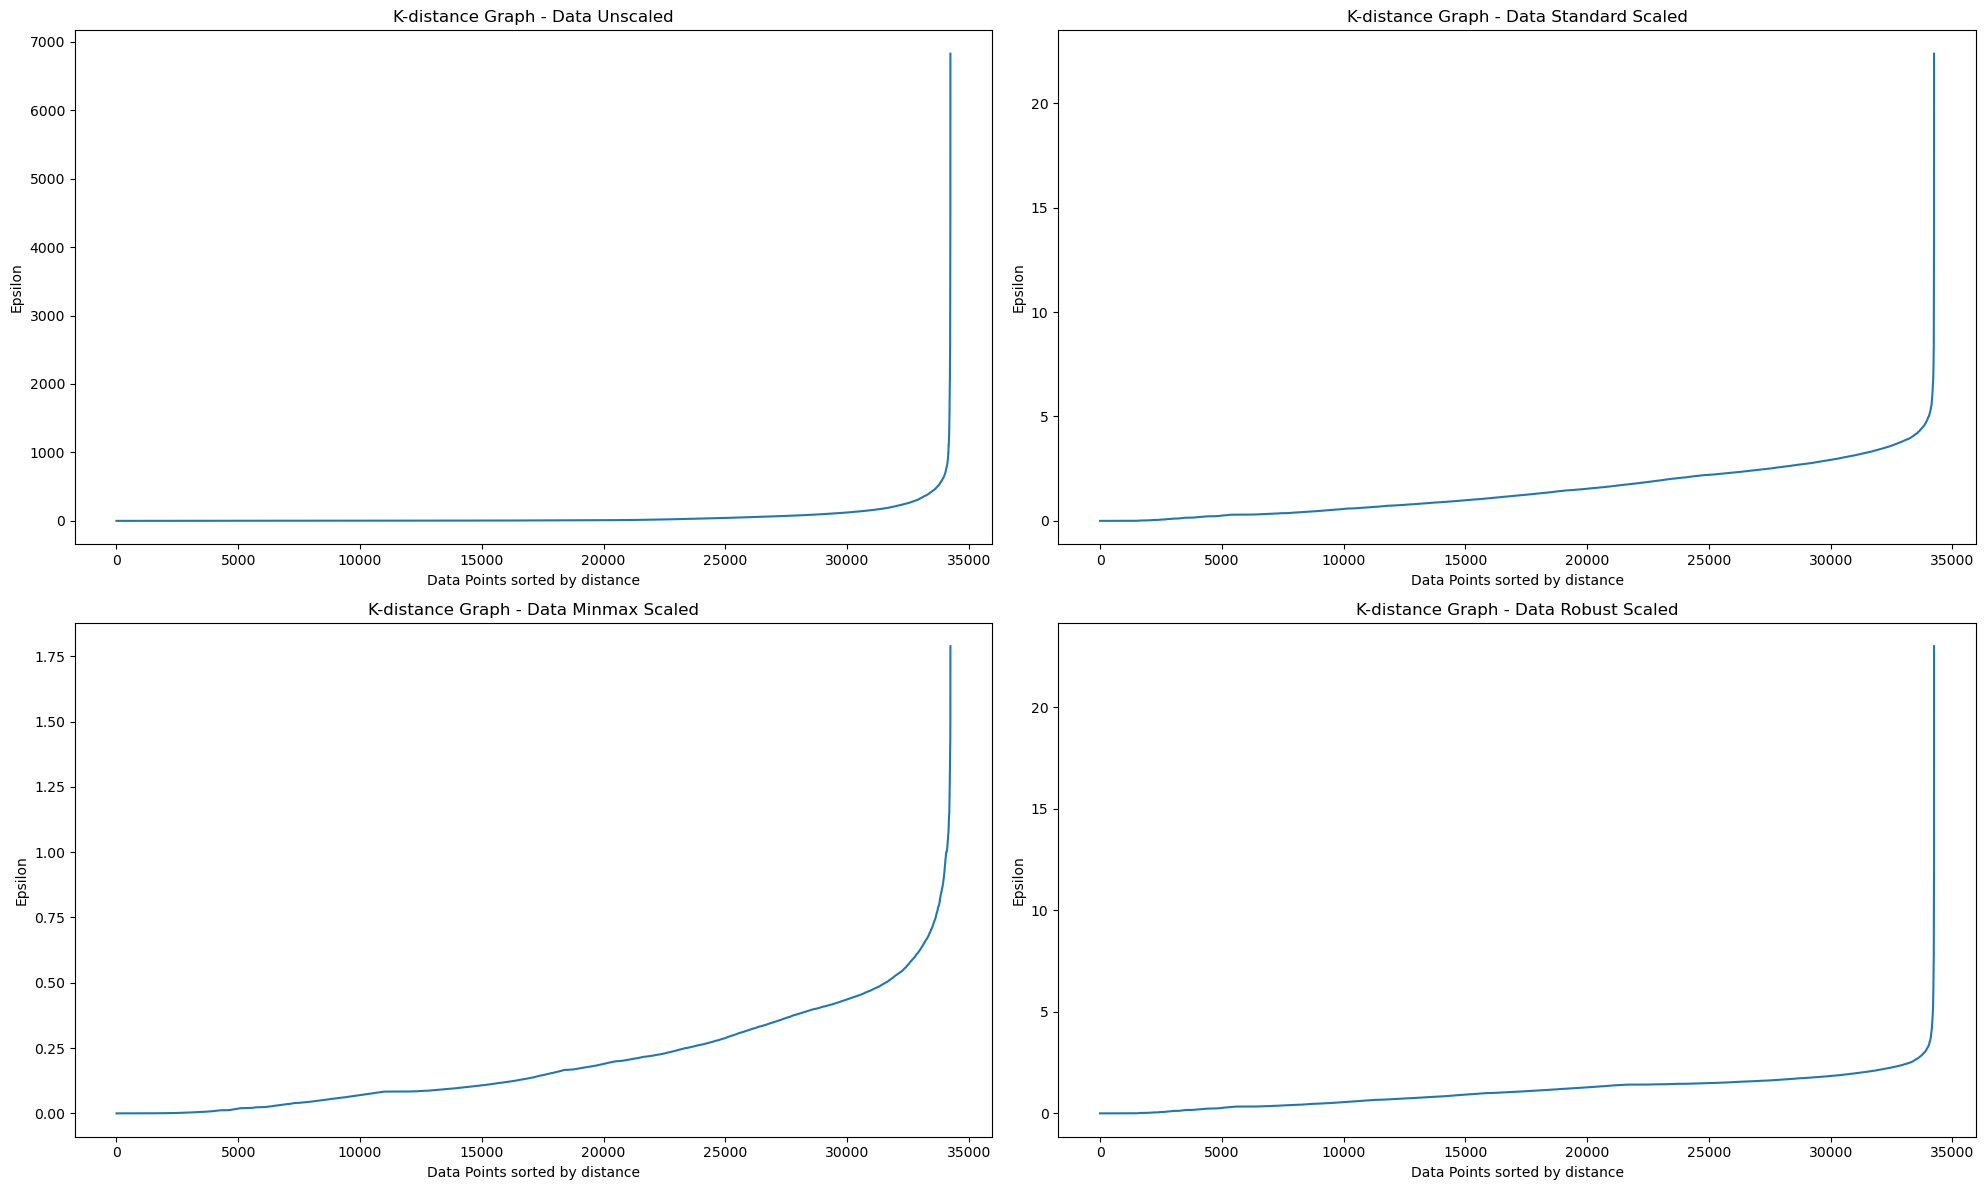

In [ ]:
k_distance_plot(clustering_df)

In [ ]:
# DBSCAN 실루엣 계수 비교

dbscan_params = {
    'method': ['DBSCAN'],
    'scaling_method': ['unscaled, standard', 'minmax', 'robust']
    'dim_reduction_method' : ['PCA', 'TruncatedSVD'],
    'n_components': [[2],[16, 17, 18, 19], [9, 10, 11], [7, 8, 9, 10]]
    'eps': [0.25, 0.3, 0.35, 0.4],
    'min_samples': [10, 30, 50, 70] 
}

dbscan_param_comb = product(*dbscan_params.values())

comparison_of_scores_dbscan(clustering_df, dbscan_param_comb, dbscan_params)

|Unscaled|Standard Scaled|
| -------------------------------------- | -------------------------------------- |
|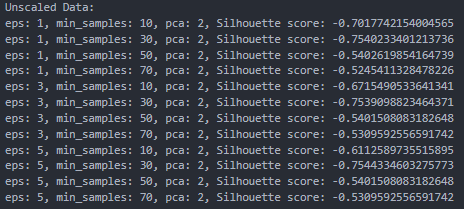|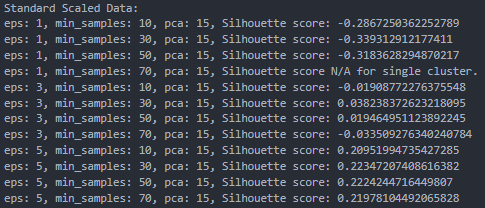|

|Minmax Scaled|Robust Scaled|
| -------------------------------------- | -------------------------------------- |
|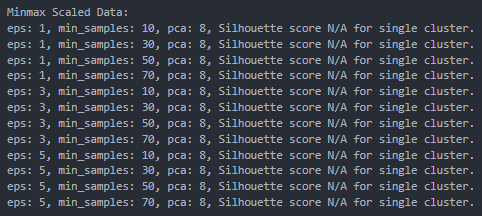|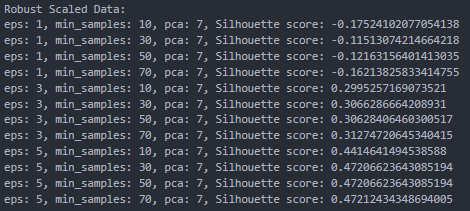|

### DBScan 예시 - DBSCAN 선정 X 
- 데이터 특성상(고차원 데이터) DBScan 클러스터링이 어렵다고 판단 
- 데이터가 여러 클러스터에 걸쳐 다양한 밀도를 갖는 경우 DBSCAN은 그러한 클러스터를 제대로 식별하지 못함 

|Unscaled|Standard Scaled|
| -------------------------------------- | -------------------------------------- |
|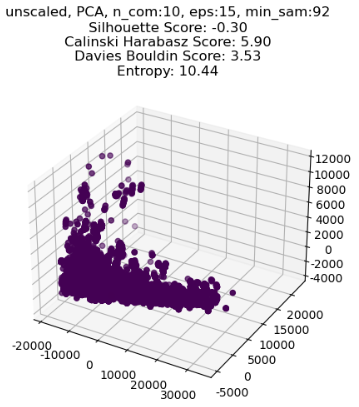|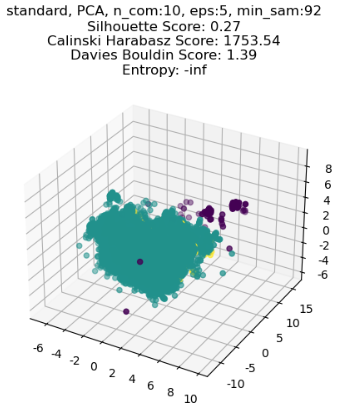|

|Minmax Scaled|Robust Scaled|
| -------------------------------------- | -------------------------------------- |
|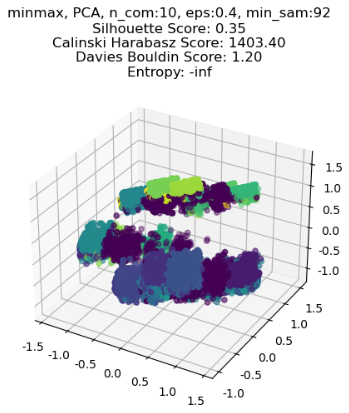|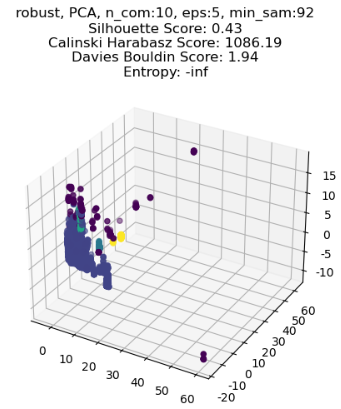|

### 3) MeanShift
1. estimate_bandwidth 메소드를 사용해 bandwidth 최적값을 구함
2. 3차원 시각화로 결과 확인

In [ ]:
MeanShift 시각화

cluster_visualization(clustering_df, method = 'MeanShift', scaling_method = 'unscaled', dim_reduction_method = 'PCA', n_components = 9)
cluster_visualization(clustering_df, method = 'MeanShift', scaling_method = 'unscaled', dim_reduction_method = 'TruncatedSVD', n_components = 9)

cluster_visualization(clustering_df, method = 'MeanShift', scaling_method = 'standard', dim_reduction_method = 'PCA', n_components = 9)
cluster_visualization(clustering_df, method = 'MeanShift', scaling_method = 'standard', dim_reduction_method = 'TruncatedSVD', n_components = 9)

cluster_visualization(clustering_df, method = 'MeanShift', scaling_method = 'minmax', dim_reduction_method = 'PCA', n_components = 9)
cluster_visualization(clustering_df, method = 'MeanShift', scaling_method = 'minmax', dim_reduction_method = 'TruncatedSVD', n_components = 9)

cluster_visualization(clustering_df, method = 'MeanShift', scaling_method = 'robust', dim_reduction_method = 'PCA', n_components = 9)
cluster_visualization(clustering_df, method = 'MeanShift', scaling_method = 'robust', dim_reduction_method = 'TruncatedSVD', n_components = 9)

#### MeanShift
- 시각화 결과, 수집한 데이터의 특성과 맞지 않는 모델 알고리즘으로 판단되어 최종 모델로 채택되지 않았음

| Unscaled, PCA                          | Standard Scaler, PCA                   | Minmax, PCA                            | Robust, PCA                            |
| -------------------------------------- | -------------------------------------- | -------------------------------------- | -------------------------------------- | 
| 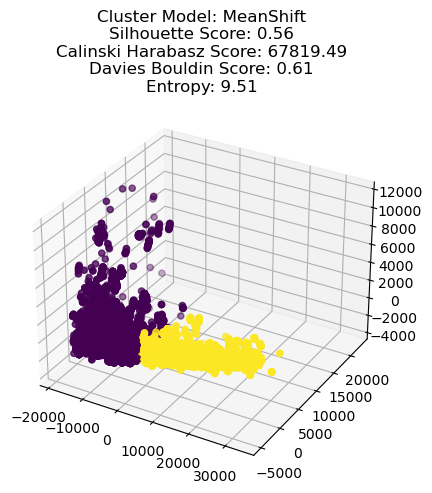 | 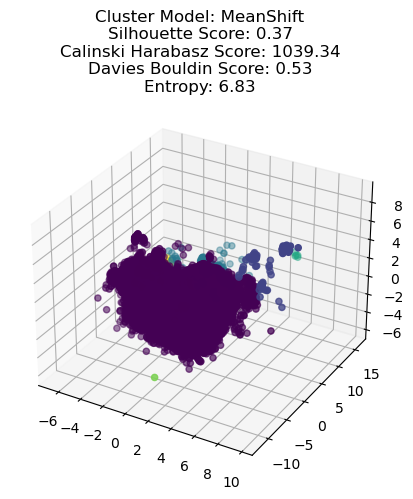 | 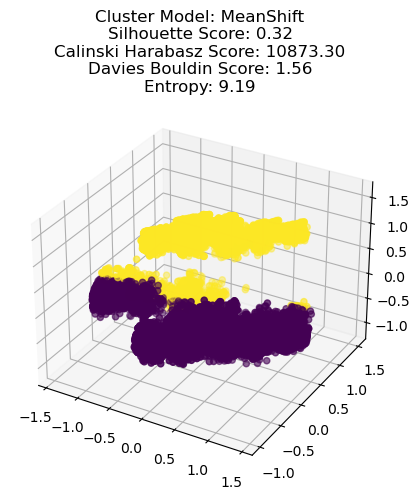 | 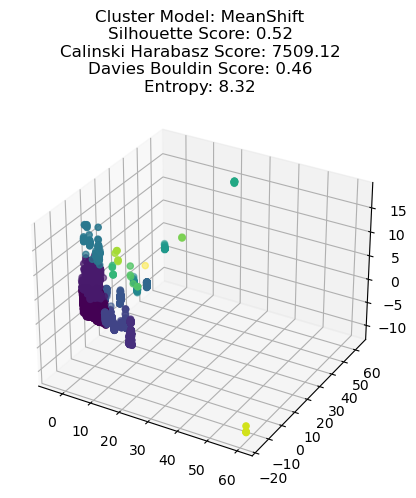 |
| **Unscaled, SVD**                      | **Standard Scaler, SVD**               | **Minmax, SVD**                        | **Robust, SVD**                        |
| 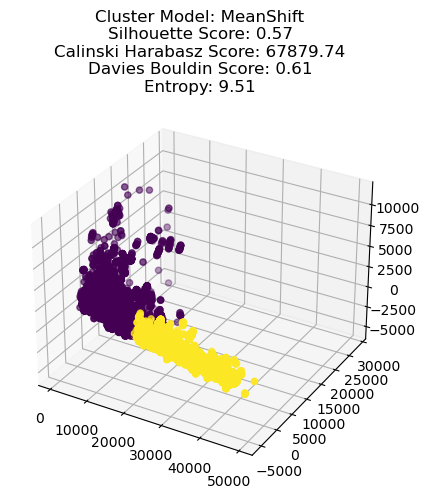 | 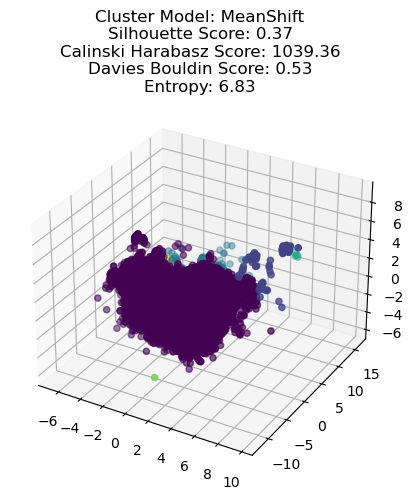 | 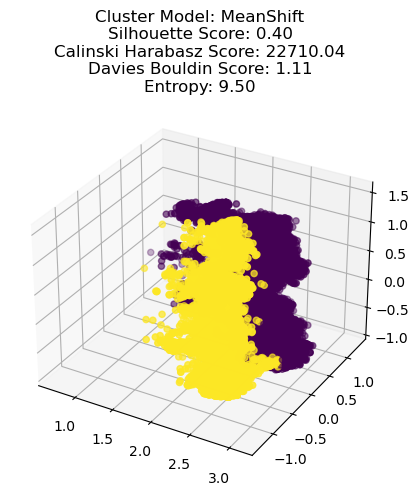 | 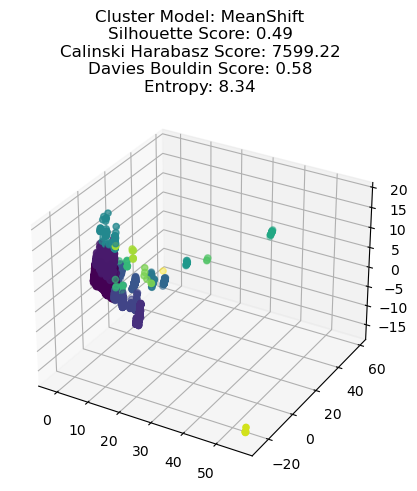     |


## 군집 중심점 분석
- 주택 유형별 (service_type 변수)로 3개의 군집이 형성됨 (원룸, 빌라 오피스텔)

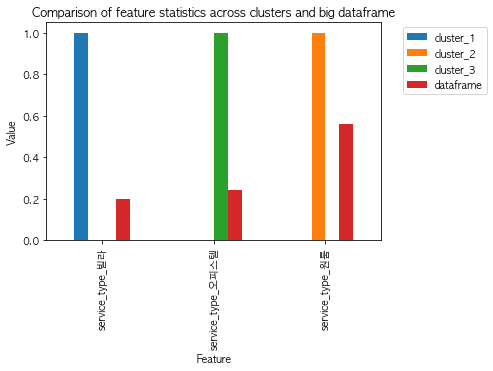

In [4]:
# 군집 특징 파악위해 각 군집의 중심점을 변수별로 시각화
params = {
    'method': "KMeans",
    'scaling_method': "minmax",
    'dim_reduction_method': "PCA",
    'n_components': 9,
    'n_clusters': 3
}

visualize_service_type(clustering_df, **params)

# 군집 모델링 발전
- service_type이 아닌 다른 변수의 특성을 반영한 군집을 보여주기 위해 service_type별로 클러스터링 진행
- 원 데이터에서 KMeans의 성능이 좋았기 때문에 분할 후 데이터에도 KMeans 군집 알고리즘을 우선 적용해보기로함

In [3]:
villa_drop_df, oneroom_drop_df, officetel_drop_df = service_type_sep(clustering_df)

### 1) 원룸

In [ ]:
cluster_visualization(oneroom_drop_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='PCA', n_components = 8, n_clusters = 6)
cluster_visualization(oneroom_drop_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='TruncatedSVD', n_components = 8, n_clusters = 6)

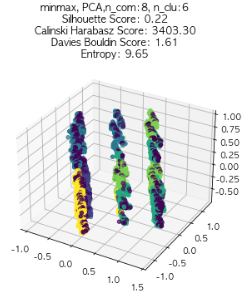 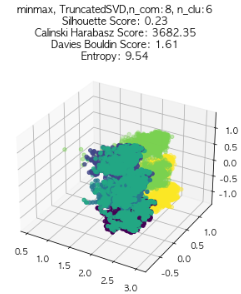

### 2) 빌라

In [ ]:
cluster_visualization(villa_drop_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='PCA', n_components = 8, n_clusters = 6)
cluster_visualization(villa_drop_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='TruncatedSVD', n_components = 8, n_clusters = 6)

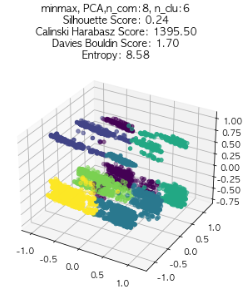 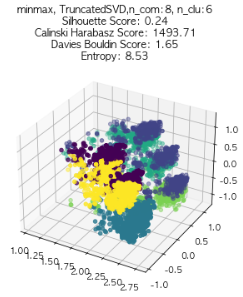

### 3) 오피스텔

In [ ]:
cluster_visualization(officetel_drop_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='PCA', n_components = 10, n_clusters = 6)
cluster_visualization(officetel_drop_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='TruncatedSVD', n_components = 10, n_clusters = 6)

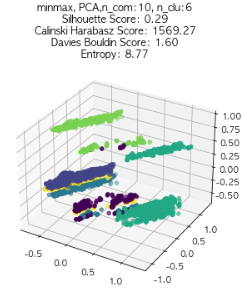 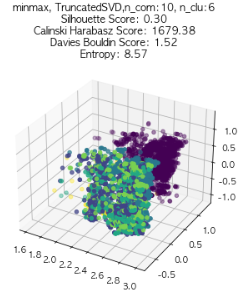

#### 차원축소 기법중 TruncatedSVD 실루엣 계수가 더 높고 시각화 결과도 유의미해서 해당 기법으로 선정 
- n_components가 8, 10이므로 너무 커서 3차원 시각화로 군집이 잘 나뉘었는지는 정확히 판단 불가 

## 주성분 특성 파악
- 군집의 특성을 파악하기 위해 차원축소 후의 주성분 특성을 파악하는 과정을 거침
- 각 주성분을 설명하는 변수를 파악하면 군집의 특성도 파악할 수 있지 않을까?

### 데이터의 수가 가장 많은 원룸 데이터를 예시로 변수별 주성분 요소 값을 계산

In [ ]:
feature_explained_variance(oneroom_drop_df, scaling_method='minmax', n_components=8, dim_reduction_method='TruncatedSVD')


|Component 1|Component 2|Component 3|Component 4|
| -------------------------------------- | -------------------------------------- |-------------------------------------- |-------------------------------------- |
|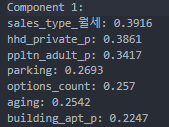|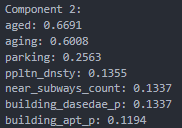|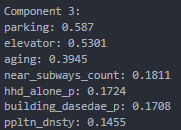|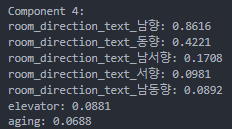|

|Component 5|Component 6|Component 7|Component 8|
| -------------------------------------- | -------------------------------------- |-------------------------------------- |-------------------------------------- |
|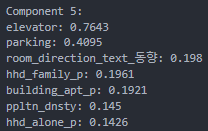|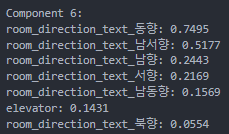|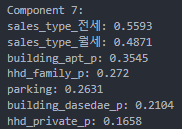|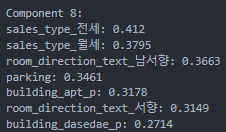|

### 각 주성분을 설명하는 변수가 다른 주성분과 차별점이 있도록 차원의 개수 축소 
- 차원의 개수 4개로 했을 떄 차별점이 보임 

In [ ]:
feature_explained_variance(oneroom_drop_df, scaling_method='minmax', n_components=4, dim_reduction_method='TruncatedSVD')


|Component 1|Component 2|Component 3|Component 4|
| -------------------------------------- | -------------------------------------- |-------------------------------------- |-------------------------------------- |
|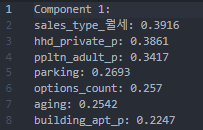|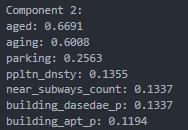|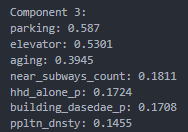|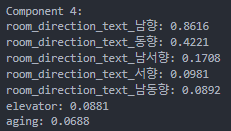|

### 차원의 개수 줄인 결과 시각화 
- 시각화 결과 / 실루엣 점수를 확인해 봤을 때 n_components = 4 설정했을 때 성능 개선 

In [ ]:
cluster_visualization(oneroom_drop_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='TruncatedSVD', n_components = 4, n_clusters = 6)
cluster_visualization(villa_drop_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='TruncatedSVD', n_components = 4, n_clusters = 6)
cluster_visualization(officetel_drop_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='TruncatedSVD', n_components = 4, n_clusters = 6)

|One Room|Villa|Officetel|
| -------------------------------------- | -------------------------------------- |-------------------------------------- |
|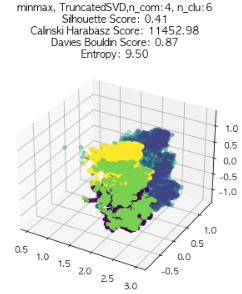|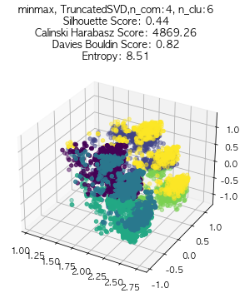|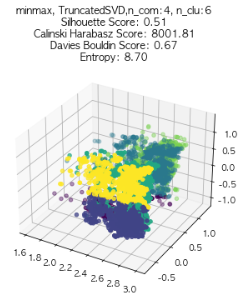|



## 군집 특성 파악
- 군집 별 유의미한 특성 파악후 폴리움 지도에 특성 반영

In [ ]:
params = {
    'method': "KMeans",
    'scaling_method': "minmax",
    'dim_reduction_method': "TruncatedSVD",
    'n_components': 4,
    'n_clusters': 6
}

cluster_center_visualize(oneroom_drop_df, **params)
cluster_center_visualize(villa_drop_df, **params)
cluster_center_visualize(officetel_drop_df, **params)

### 유의미한 특성 그래프 예시: 
- 차별점/특성 폴리움 지도 군집 결과에 반영 

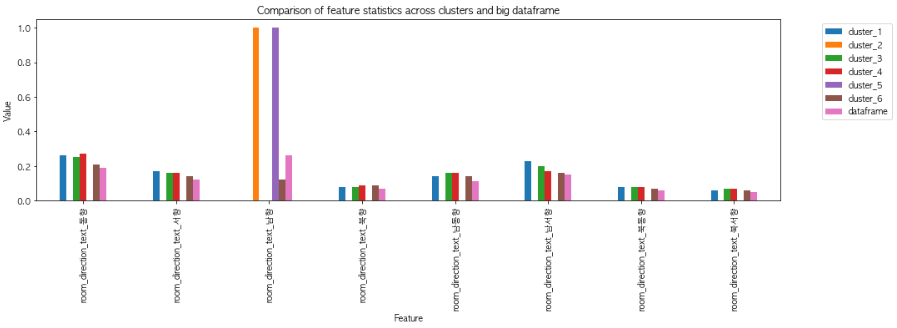

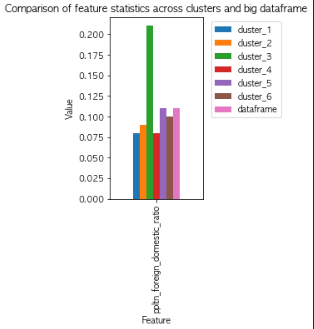 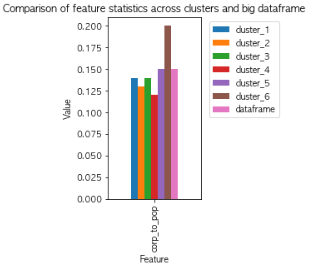 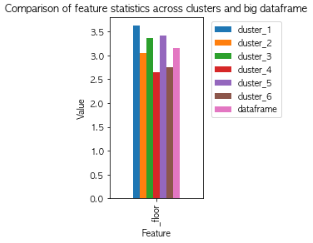

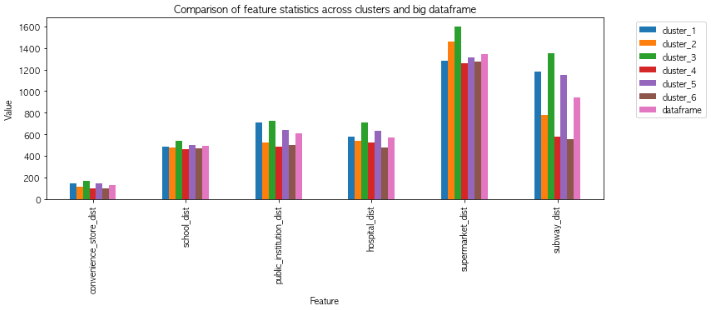